In [57]:
#Wir importieren die benötigten Bibliotheken

#algebrische Datentypen a'la matlab.
import numpy as np

#angepasste Plot-Funkionen
from libtank import plot_results

#allgemeine Plot-Funkionen a'la Matlab
import matplotlib.pyplot as pp

#Funktion für die Simulation der Modelle
from scipy.integrate import solve_ivp

#allgemeinen Funktionen für MIMO-Systeme
import libmimo as mimo

#zum einacheren Handling von Reimporten geänderter Bibliotheken
import importlib as imp

#Computeralgebra (Hier nur für die Ausgabe)
import sympy



In [58]:
#Parameter des Viertank-Systems importieren
import settings as st

#Interessierende Ruhelagen anhand der Ausgänge y1=x3 und y2=x3 definieren
y1 = np.array([0.15,0.15])
y2 = np.array([0.12,0.18])
y3 = np.array([0.18,0.12])
y4 = np.array([0.16,0.14])
y5 = np.array([0.14,0.16]) #angepasst nach Angabe

y_equi=[y1,y2,y3,y4,y5]

#zu betrachtende Übergänge (RL2 nach RL3 sowie RL4 nach RL5) laut Aufgabenstellung
transitions = [(2,3),
               (4,5)]



# 1 Modelle des Tanksystems

## a) Nichlineares Modell

Implementieren Sie das nichtlineare Modell, wie in der Aufgabenstellung beschrieben.

### Dokumentation: Nichtlineares Modell des Viertanksystems

Das Viertanksystem beschreibt die Dynamik der Füllstände $x_1, x_2, x_3, x_4$ in vier miteinander verbundenen Tanks. Die zeitliche Änderung der Füllstände basiert auf einer Volumenbilanz, die für jeden Tank formuliert wird. Die allgemeine Form lautet:

$$
\dot{x}_i(t) = \left( Q_{\text{in}, i}(t) - Q_{\text{out}, i}(t) \right),
$$

$Q_{\text{in}, i}(t)$ beschreibt die die Zuflüsse in Tank $i$ und $Q_{\text{out}, i}(t)$ die Abflüsse aus Tank $i$

Die Zuflüsse in das System werden durch die Pumpen erzeugt, deren Volumenströme proportional zur Spannung $u_i(t)$ sind. Das Pumpenmodell lautet:

$$
Q_{\text{zu}, i}(t) =
\begin{cases}
K_U \cdot (u_j(t) - u_{0j}), & \text{für } u_j(t) <= u_{0j}, \\
0, & \text{sonst}.
\end{cases}
$$

Die Abflüsse zwischen den Tanks sowie ins Reservoir folgen dem Torricelli-Gesetz, das durch folgende Gleichung beschrieben wird:

$$
Q_{ab}(t) =
\begin{cases}
a \sqrt{2g \left(x(t) + h_V\right)}, & \text{falls } x(t) \geq 0, \\
0, & \text{falls } x(t) < 0,
\end{cases}
$$


Ausgehend von diesen physikalischen Grundlagen ergeben sich die Differentialgleichungen des Viertanksystems. Diese können aius den gegebenen Gleichungen 4a-4d hergeleitet werden: 

1. Für Tank 1:
$$
\dot{x}_1(t) = \frac{1}{A_1} \left( Q_{01}(t) - Q_{12}(t) - Q_{13}(t) \right),
$$
1. Für Tank 2:
$$
\dot{x}_2(t) = \frac{1}{A_2} \left( Q_{02}(t) + Q_{12}(t) - Q_{23}(t) - Q_{24}(t) \right),
$$
1. Für Tank 3:
$$
\dot{x}_3(t) = \frac{1}{A_3} \left( Q_{13}(t) + Q_{23}(t) - Q_{34}(t) - Q_{30}(t) \right),
$$
1. Für Tank 4:
$$
\dot{x}_4(t) = \frac{1}{A_4} \left( Q_{24}(t) + Q_{34}(t) - Q_{40}(t) \right).
$$

Die Implementierung des Modells erfolgt in der Funktion `model`, welche die Zuflüsse mit der Methode `get_flow_from_input` und die Abflüsse mit der Methode `get_outflow_from_level` berechnet. So kommen die jeweiligen $Q_{ij}$ zustande. Die berechneten Zuflüsse und Abflüsse werden in die oben genannten Differentialgleichungen eingesetzt, um die Zustandsänderungen $\dot{x}(t)$ zu berechnen. In der Fallunterscheidung für den Querschnitt A je nach Höhe des Füllstandes x, wird berücksichtigt, auch im Abflussschlauch zwischen Tank und Ventil Flüssigkeit speichern kann.
Um Den Ausgang (Die Funktion `output`) korrekt aufzustellen, werden die Tanks 3 und 4 betrachtet, dies ist in der Angabe gegeben. Je nachdem ob die angegebene Zeit ein bestimmter Zeitpunkt (float) oder eine Zeitreihe (array) ist, sind die Matrixdimensionen anders (Zeitpunkt: Spaltenvektor, Zeitreihe: Matrix).

In [59]:
#Reimport der Viertank-Bibliothek
import libtank
imp.reload(libtank)
from libtank import VierTank;

#Modell prüfen
tank=VierTank(st)

tank.verify_model("testdata.pckl")

Maximaler absoluter Fehler in Modellgleichung (euklidische Norm): 0.0
Maximaler relativer Fehler in Modellgleichung (euklidische Norm): 0.0
Maximaler absoluter Fehler in Ausgangsgleichung (euklidische Norm): 0.0
Maximaler relativer Fehler in Ausgangsgleichung (euklidische Norm): 0.0


Wenn die Fehler gering sind, verhält sich das aufgestellte Modell gut zu den Testdaten.

## b) Bestimmung der Ruhelagen

Ergänzen Sie hier hier Ihre Überlegungen zur Bestimmung der Ruhelagen und implementieren Sie das Ergebnis in der Methode `equilibrium` der Klasse `VierTank`.

Die nächste Zelle dient zunächst zum Test Ihrer Implementierung: Wenn die Ruhelagen in die Modellgleichungen eingesetzt werden, sollte  

Die Ruhelagen können bestimmt werden, durch die Gleichsetzung der Ableitungen der Zustandsgrößen gleich Null. Daraus könenn dann die Gleichgewichts-Füllstande $\bar{x_1}(t)...\bar{x_4}(t)$ und die Gleichgewichts-Pumpenspannungen $\bar{u_1}(t), \bar{u_2}(t)$ bestimmt werden, indem die resultierenden nichtlinearen Gleichungssysteme nach diesen umgestellt werden. 
Außerdem sollte überprüft werden, ob die gefunden Ruhelagen auch innerhalb der systembedingten Grenzen liegen und physikalisch möglich sind. (siehe Hinweis Angabe) Dies wird in einer If-Abfrage berücksichtigt und als equi_status übergegeben. 

In [60]:
#Reimport der Viertank-Bibliothek
import libtank
imp.reload(libtank)
from libtank import VierTank;

tank=VierTank(st)

equis=[]

#Berechnung der zugehörigen Ruhelagenzustände und Eingänge
for i_, y_ in enumerate(y_equi):
    #Ruhelage berechnen
    _equi=tank.equilibrium(y_)
    equis.append(_equi)

    # Prüfen: hier sollte möglichst 0 herauskommen
    dx_equi = tank.model(0, _equi.x, lambda t,x:_equi.u)
    print("Ableitungstest Ruhelage " + str(i_+1) + ": " + str(dx_equi))

Ableitungstest Ruhelage 1: [-2.15695169e-17 -1.07847584e-17  0.00000000e+00  0.00000000e+00]
Ableitungstest Ruhelage 2: [ 0.00000000e+00 -2.15695169e-17  0.00000000e+00  0.00000000e+00]
Ableitungstest Ruhelage 3: [-1.07847584e-17  1.07847584e-17  0.00000000e+00  0.00000000e+00]
Ableitungstest Ruhelage 4: [1.07847584e-17 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Ableitungstest Ruhelage 5: [-3.23542753e-17  3.23542753e-17  0.00000000e+00  0.00000000e+00]


Das Ergebniss des Ableitungstest zeigt, dass die Zahlen nahe 0 sind, somit ist dies zulässig.

Auf der Basis wird nun eine Grafik aller zulässigen Ruhelagen erstellt.

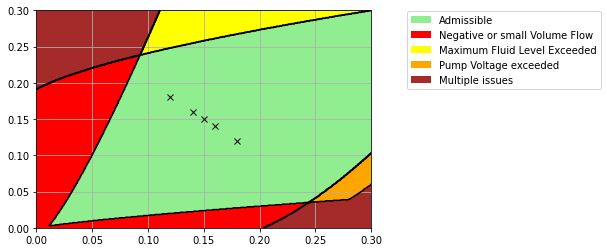

In [61]:
#Reimport der Viertank-Bibliothek
import libtank
imp.reload(libtank)
from libtank import VierTank;

#Bestimmen aller zulässigen Ruhelagen
tank=VierTank(st)

#Auflösung
N=401
M=np.zeros((N,N))

#Stützstellen Ausgangsfüllhöhen
_y1_array=np.linspace(0,0.3,N)
_y2_array=np.linspace(0,0.3,N)

#Ruhelagen zu allen Stütstellen berechnen
for _i, _y1 in enumerate(_y1_array):
    for _j, _y2 in enumerate(_y2_array):
        _equi = tank.equilibrium([_y1,_y2])
        color_code = [0,1,2,4,3,4,4,4]
        M[_j,_i]=color_code[_equi.status]


#Plotten
fig = pp.figure();
cs=pp.contourf(_y1_array,_y2_array,M,[-0.5,0.5,1.5,2.5,3.5,4.5],colors=['lightgreen','red','yellow','orange','brown'])
pp.contour(_y1_array,_y2_array,M,[-0.5,0.5,1.5,2.5,3.5,4.5],colors='black')
ax=pp.gca()
ax.set_xlim(0,0.3)
ax.set_ylim(0,0.30)


labels=["Admissible","Negative or small Volume Flow","Maximum Fluid Level Exceeded","Pump Voltage exceeded","Multiple issues"]
proxy = [pp.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0])
        for pc in cs.collections]
pp.legend(proxy, labels,bbox_to_anchor=(1.7, 1.02))
for _i in range(len(labels)):
    cs.collections[_i].set_label(labels[_i])
#for _i,_y in enumerate(y_equi):
pp.plot(np.array(y_equi)[:,0],np.array(y_equi)[:,1],"kx")
pp.grid()
pp.show()


Um die Prüfung der gefundenen Lösung durchzuführen werden hier die Ruhelagen numerisch durch Einsetzten der Werte aus Tabelle 2 überprüft.

In [62]:
#Reimport der Viertank-Bibliothek
import libtank
imp.reload(libtank)
from libtank import VierTank;

#Bestimmen aller zulässigen Ruhelagen
tank=VierTank(st)

# Ruhelage 1:(y1, y2) = (0.15, 0.15)
y_equi1 = np.array([0.15, 0.15])
equi1 = tank.equilibrium(y_equi1)
#Einsetzen in das Modell aus 1 a) 
equi = tank.model(0, equi1.x, lambda t, x: equi1.u)
print("Ableitungen dx für Ruhelage1: ", equi)

# Ruhelage 2:(y1, y2) = (0.12, 0.18)
y_equi2 = np.array([0.12, 0.18])
equi2 = tank.equilibrium(y_equi2)
equi = tank.model(0, equi2.x, lambda t, x: equi2.u)
print("Ableitungen dx für Ruhelage2: ", equi)

# Ruhelage 3:(y1, y2) = (0.18, 0.12)
y_equi3 = np.array([0.18, 0.12])
equi3 = tank.equilibrium(y_equi3)
equi = tank.model(0, equi3.x, lambda t, x: equi3.u)
print("Ableitungen dx für Ruhelage3: ", equi)

# Ruhelage 4:(y1, y2) = (0.16, 0.14)
y_equi4 = np.array([0.16, 0.14])
equi4 = tank.equilibrium(y_equi4)
equi = tank.model(0, equi4.x, lambda t, x: equi4.u)
print("Ableitungen dx für Ruhelage4: ", equi)

# Ruhelage 5:(y1, y2) = (0.14, 0.16)
y_equi5 = np.array([0.14, 0.16])
equi5 = tank.equilibrium(y_equi5)
equi = tank.model(0, equi5.x, lambda t, x: equi5.u)
print("Ableitungen dx für Ruhelage5: ", equi)



Ableitungen dx für Ruhelage1:  [-2.15695169e-17 -1.07847584e-17  0.00000000e+00  0.00000000e+00]
Ableitungen dx für Ruhelage2:  [ 0.00000000e+00 -2.15695169e-17  0.00000000e+00  0.00000000e+00]
Ableitungen dx für Ruhelage3:  [-1.07847584e-17  1.07847584e-17  0.00000000e+00  0.00000000e+00]
Ableitungen dx für Ruhelage4:  [1.07847584e-17 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Ableitungen dx für Ruhelage5:  [-3.23542753e-17  3.23542753e-17  0.00000000e+00  0.00000000e+00]


## c) Simulation des nichtlinearen Modells

Führen Sie an dieser Stelle die Simulationsstudie des nichtlinearen Modells durch und interpretieren Sie die Ergebnisse. An dieser Stelle ist keine Programmierarbeit zu leisten.

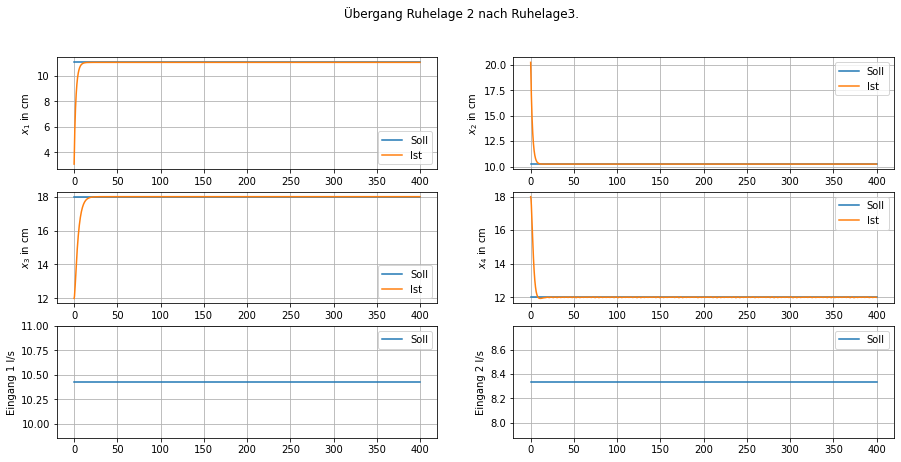

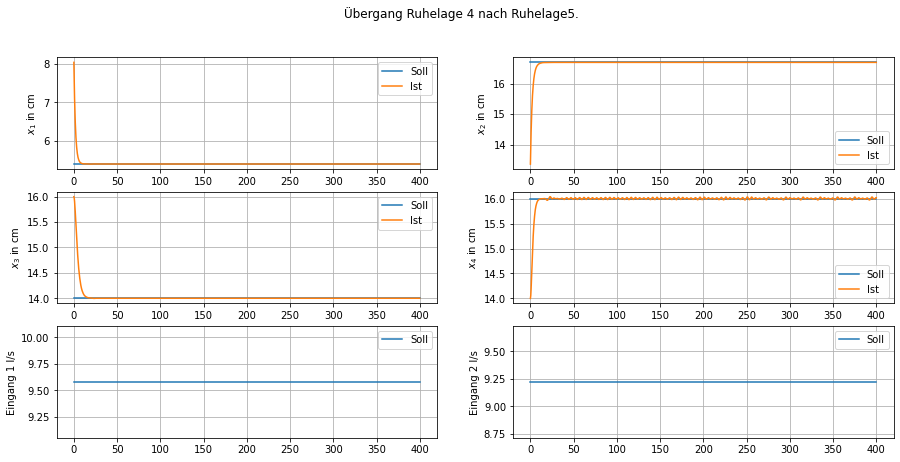

In [63]:
#Modell neu laden
import libtank
imp.reload(libtank)
from libtank import VierTank;
tank=VierTank(st)

# Ein "Regler" der den Eingang konstant hält
def constant_controller(t,x,u):
    if x.ndim==1:
        return u
    else:
        return np.diag(u)@np.ones((2,x.shape[1]))

#Simulationszeit
Tsim=400

for _i, _transition in enumerate(transitions):

    #Anfangszustand
    _x0 = equis[_transition[0]-1].x

    #Endzustand
    _x1 = equis[_transition[1]-1].x

    #konstantes Stellsignal ensprechend Endruhelage
    _u0 = equis[_transition[1]-1].u


    #Auswertungszeitpunkte
    t_eval=np.linspace(0,Tsim,1000)

    #Wrapper für rechte Seite der Differentialgleichung
    _ctrl = lambda t,x: constant_controller(t,x,_u0)
    _rhs = lambda t,x:tank.model(t,x,_ctrl)

    #Modell simulieren
    res = solve_ivp(_rhs,#zu simulierendes Modell
                    [0,Tsim],#Zeitspanne für Simulation
                    _x0,#Anfangszustand
                    t_eval=t_eval,#Auswertungszeitpunkte
                    atol=1e-6,rtol=1e-3 #Toleranzen
                    )

    #Ergebnisse Plotten
    x=res.y
    u=_ctrl(t_eval,x)
    _xx=np.tile(_x1,(t_eval.shape[0],1)).T
    plot_results(t_eval,(_xx,x),(u,))
    pp.gcf().suptitle('Übergang Ruhelage '+ str(_transition[0]) + ' nach Ruhelage' + str(_transition[1]) + '.')
    pp.show()

Die beiden Grafiken zeigen den Übergang von einer Ruhelage in die nächste. Es wird jeweils schnell von einem Ausgangsfüllstand in die nächste Ruhelage gewechselt und dieser Füllstand bleibt dann stabil. Das bedeutet eine rasche Anpassung ohne Überschwingen. 
Die Übergangszeiten wirken vergleichsweise kurz (10 Sekunden). Sobald die Ruhelagen erreicht sind, verweilt der Zustand in dieser, was eine Charakteristik dafür ist.

## d) Lineares Modell des Tanksystems

Fügen Sie hier Ihre Überlegungen zur Linearisierung ein. Die Ergebnisse sind in der Methode `linearize` der Klasse `VierTank`zu implementieren. Aus der nächsten Zelle werden die Ergebnisse aufgerufen und numerisch überprüft. Es werden ausserdem die Eigenwerte entsprechenden Systemmatrizen berechnet. Interpretieren Sie anhand dieser Eigenwerte kurz die Simulationsergebnisse der vorangegangenen Teilaufgabe.

Für die Linearisierung um eine beliebeige Ruhelage, wird die Ruhelage an die Funktion `linearize` übergeben. Diese  werden die händisch berechneten Ableitungen eingesetzt. Es werden die Jacobi-Matrizen (welche die Systemmatrizen darstellen) aufgestellt.

In [64]:
#Modell neu laden
import libtank
imp.reload(libtank)

from libtank import VierTank;

tank=VierTank(st)



for _i, y_ in enumerate(y_equi):
    print("Ruhelage "+ str(_i+1) +":")
    print("===========")
    #Prüfen des Regimes
    _equi=tank.equilibrium(y_)
    
    #Berechnung der Linearisierung
    tank_lin = tank.linearize(_equi)

    #Prüfen der Linearisierung
    A,B,C=tank.verify_linearization(tank_lin)

    #Eigenwerte berechnen
    print("Eigenwerte : " + str(np.linalg.eigvals(tank_lin.A)))
    print()


Ruhelage 1:
Maximaler absoluter Fehler in Matrix A Zeile 4, Spalte 3 beträgt 1.8285067904244556e-11.
Maximaler relativer Fehler in Matrix A Zeile 4, Spalte 3 beträgt 1.0694276411328209e-10.
Maximaler absoluter Fehler in Matrix C Zeile 1, Spalte 1 beträgt 0.
Maximaler relativer Fehler in Matrix C Zeile 1, Spalte 1 beträgt 0.0.
Maximaler absoluter Fehler in Matrix B Zeile 2, Spalte 2 beträgt 2.7636559707389097e-11.
Maximaler relativer Fehler in Matrix B Zeile 1, Spalte 1 beträgt 7.690104373128232e-10.
Maximaler absoluter Fehler in Matrix D Zeile 1, Spalte 1 beträgt 0.0.
Maximaler relativer Fehler in Matrix D Zeile 1, Spalte 1 beträgt 0.0.
Eigenwerte : [-0.68391978 -0.34195989 -0.38470488 -0.53858683]

Ruhelage 2:
Maximaler absoluter Fehler in Matrix A Zeile 1, Spalte 1 beträgt 2.8292590492640102e-11.
Maximaler relativer Fehler in Matrix A Zeile 2, Spalte 1 beträgt 6.322606356873636e-11.
Maximaler absoluter Fehler in Matrix C Zeile 1, Spalte 1 beträgt 0.
Maximaler relativer Fehler in Matr

Zuletzt sollen sie Eigenwerte der Systemmatrizen numerisch berechnet werden. Dies geschieht bereits im vorgesetzten Code und wird deshalb nicht erneut durchgeführt. Die Eigenwerte beschreiben die Dynamik des Systems. Alle Eigenwerte haben negative Realteile, was bedeutet die Ruhelage ist asymptotisch stabil. Das System kehrt schnell in die Ruhelage zurück, welches sich auch auf den Abbildungen erkennen lässt (ein schneller Wechsel in die nächste stabile Ruhelage).

# 2 Zeitkontinuierlicher Entwurf

In [65]:
#In diesem Abschnitt wird durchgehend die Ruhelage 1 für den Entwurf genutzt
tank=VierTank(st)
tank_lin=tank
tank_lin = tank.linearize(equis[0])

#Übergangszeit ist jeweils 50s
T=50.0

## a) Steuerbarkeit

Ergänzen Sie hier Ihre Überlegungen zu Teilaufgab a).

Die Steuerbarkeit des linearisierten Systems kann mithilfe des Kalmannschen Kriteriums gelöst werden. Ein System ist steuerbar, wenn die Steuerbarkeitsmatrix S vollen Rang n besitzt. Zuerst wird also S berechnet, wobei die Matrizen A und B aus der linearen Zustandsraumdarstellung des Systems in Ruhelage 1 verwendet werden. Hierfür wird mit der Methode `linearize` aus `libtank.py` die Systemmatrizen berechnet.

$S = \begin{bmatrix} B & AB & A^2B & \cdots & A^{n-1}B \end{bmatrix}$

Die Steuerbarkeitsmatrix kann mit der Funktion  `controllability_matrix` in der Datei `libmimo.py` berechnet werden.


Weiter wird mithilfe des Rangs überprüft ob das System steuerbar ist, dabei gilt: Das Sytem ist steuerbar, wenn $\text{Rang}(S) = n$, wobei $n$ der Anzahl der Zustandsvariablen entspricht.

Kronecker-Indizes: Die Kronecker-Indizes werden bestimmt, indem untersucht wird, wie die Steuerbarkeitsmatrix eines Mehrgrößensystems aufgebaut ist und wie der Rang dieser Matrix in Abhängigkeit von verschiedenen Kombinationen der Steuerbarkeitsvektoren wächst.
Diese Vektoren entsprechen der Minmialen Anzahl von Zustandsvariablen, die erforderlich sind um das System vollständig zu steuern. Ihre Summe entspricht $n$.
Das Ziel ist, alle Kombinationen von Indizes zu finden, die zu einer Steuerbarkeitsmatrix mit vollem Rang führen.

In [66]:
# Hier den Code zu Teilaufgabe a) ergänzen
# Import der notwendigen Funktionen
from libmimo import controllability_matrix

# Zugriff auf die Systemmatrizen
A, B, C, D = tank_lin.A, tank_lin.B, tank_lin.C, tank_lin.D

# Steuerbarkeitsmatrix berechnen
S = controllability_matrix(A, B)

# Rang der Steuerbarkeitsmatrix überprüfen
rank_S = np.linalg.matrix_rank(S)
state_dim = A.shape[0]

if rank_S == state_dim:
    print("Das System ist steuerbar.")
else:
    print("Das System ist nicht steuerbar.")


# Bestimmung der Kronecker-Indizes

n = []
#Erster Eingang (=erste Spalte von B)
b1 = B[:, 0:1]
#zweiter Eingang
b2 = B[:, 1:2]

for i in range(1, 4):
    Sn_b1 = np.hstack([np.linalg.matrix_power(A, j) @ b1 for j in range(i)])     #Sn_b1: Enthält Steuerbarkeitsvektoren für den ersten Eingang mit Länge i
    Sn_b2 = np.hstack([np.linalg.matrix_power(A, j) @ b2 for j in range(4 - i)])  # Sn_b2: Enthält Steuerbarkeitsvektoren für den zweiten Eingang mit Länge 4−i.

    Sn = np.hstack((Sn_b1, Sn_b2)) # Teilmatrizen werden mit np.hstack (horizontales Zusammenfügen) kombiniert.
    
    # Rangprüfung
    if np.linalg.matrix_rank(Sn) == state_dim:
        n.append([i, 4-i])
print("Es folgen alle möglichen Kronecker-Indizies (n1,n2) für Ruhelage 1 um den vollen Rang zu erreichen")
display(n)



Das System ist steuerbar.
Es folgen alle möglichen Kronecker-Indizies (n1,n2) für Ruhelage 1 um den vollen Rang zu erreichen


[[1, 3], [2, 2], [3, 1]]

Das System ist steuerbar. Die Kombinationen der Kronecker-Indizes sind alle möglichen Kombinationen um den vollen Rang zu bekommen. Wir wählen die Kobination [2, 2], diese kann später dazu verwendet werden um das System in Regelungsnormalform zu transformieren ( `mimo_rnf(tank_lin.A,tank_lin.B,tank_lin.C,(2,2))` ). 

## b) Trajektorienplanung

Ergänzen Sie hier Ihre Überlegungen zu Teilaufgabe b).

Führen Sie die in der Angabe angegebenen Anpassungen der Algorithmen in der Klasse `ContinuousFlatnessBasedTrajectory` in der Datei `libtank.py` durch.

Interpretieren Sie Anhand der Transformationsmatrix $Q$ auf Regelungsnormalform die Bedeutung des flachen Ausgangs (mündlich).

In [67]:
from libmimo import mimo_rnf

## Hier die Kommentare entfernen und Interpretation des flachen Ausgangs anhand der Matrix Q diskutieren

mimo_rnf(tank_lin.A,tank_lin.B,tank_lin.C,(2,2))
_, _, _,_, Q, S = mimo_rnf(tank_lin.A,tank_lin.B,tank_lin.C,(2,2))
display(sympy.Matrix(Q.round(2)))

Matrix([
[  0.0,   0.0,  71.42, -17.86],
[29.92,   0.0, -27.48,  12.21],
[  0.0,   0.0,    0.0,  53.26],
[  0.0, 27.32,   9.11, -36.42]])

Mit Q werden die ursprünglichen x (Füllstände) in Regelungsnormalform transformiert.Die Einträge können für die Bestimmung des flachen Ausgangs genutzt werden. Um die Zustandstrajektorie später zu beschreiben kann Q genutz werden um xrnf in unser x relativ zum Arbeitspunkt zu transformieren. 

Die Umrechnung zwischen den stationären Werten eta_a und eta_b des flachen Ausgangs und ya und yb des Systemausgangs wird im Konstruktor der Klasse ContinuousFlatnessBasedTrajectory durchgeführt. Die Umrechnung geschieht über die Berechnungsvorschrift:
$$
\eta_b = \mathbf{C}_{\text{RNF}}^{-1} \cdot \mathbf{y}_b^{\text{rel}}
$$
Die Crnf wird mit dem Kroneclker Paar um die 2. und 4. Spalte reduziert.

Die Zustandstrajektorie wird in der Funktion state berechnet. Dafür werden eta und alle zeitlichen Ableitungen von eta die benötigt werden berechnet. 
Der Vektor wird dann relativ zum Arbeitspunkt (=Abweichung des Aktuellen Systemzustands) mit der Matrix Q transformiert um diesen dann in Bezug zur Ruhelage berechnen zu können. 

## c) Steuerungsentwurf

Testen Sie hier Ihre Implementierung und interpretieren Sie die Ergebnisse.

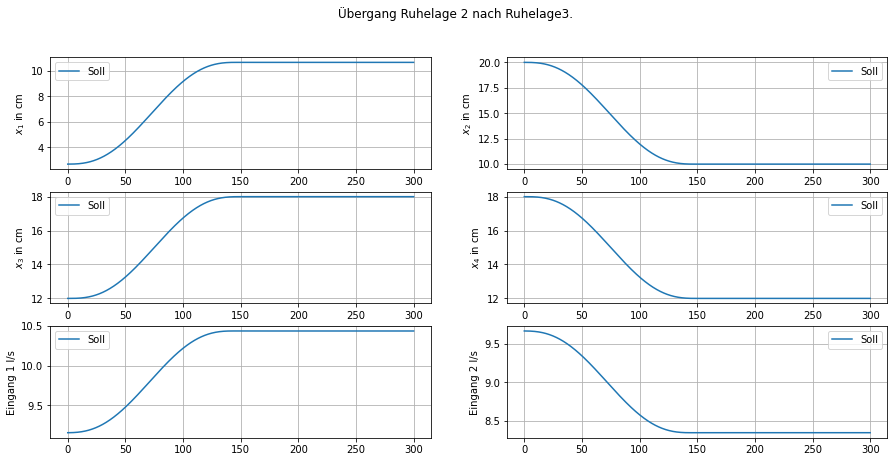

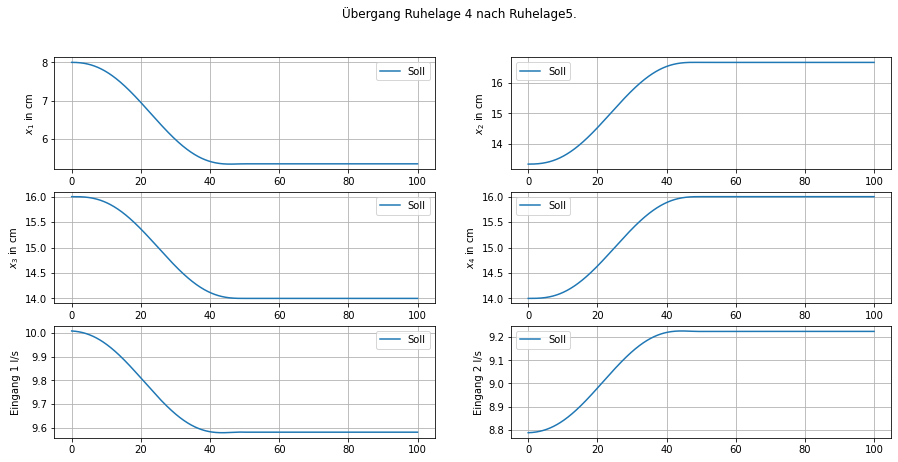

In [81]:
#importiere benötigte Funktion
imp.reload(libtank)

#Übergangszeit für Trajektorie
Tsim=2*T

#Übergangszeit bitte ggf. anpassen
T = [150,50]

#Generiere Solltrajektorien für das linearisierte System
for _i, _transition in enumerate(transitions):

    _T = T[_i]

    #Simulationszeit

    Tsim = 2*_T

    #Anfangs- und Endruhelage abrufen
    _ya = y_equi[_transition[0]-1]
    _yb = y_equi[_transition[1]-1]
    #_ya=np.array(y_equi[0])
    #_yb=np.array(y_equi[1])

    #Trajekorie generieren
    _trajectory=tank_lin.rest_to_rest_trajectory(_ya,_yb,_T,(2,2))

    #Ergebnisse Plotten
    tv=np.linspace(0,Tsim,1000)
    _x_soll = _trajectory.state(tv)
    _u_soll = _trajectory.input(tv)
    plot_results(tv,(_x_soll,),(_u_soll,))
    pp.gcf().suptitle('Übergang Ruhelage '+ str(_transition[0]) + ' nach Ruhelage' + str(_transition[1]) + '.')
    pp.show()




Zum Test der bisherigen Schritte wird die Planung mit der Simulation verglichen. Zumindest bei der Simulation mit dem linearen Modell sollten die geplanten und die simulierten Trajektorien jeweils übereinanderliegen.

## d) Simulation der Steuerung

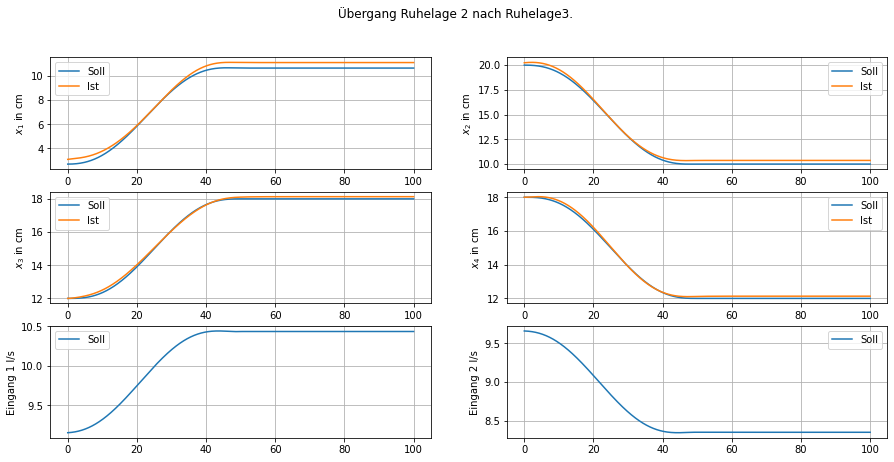

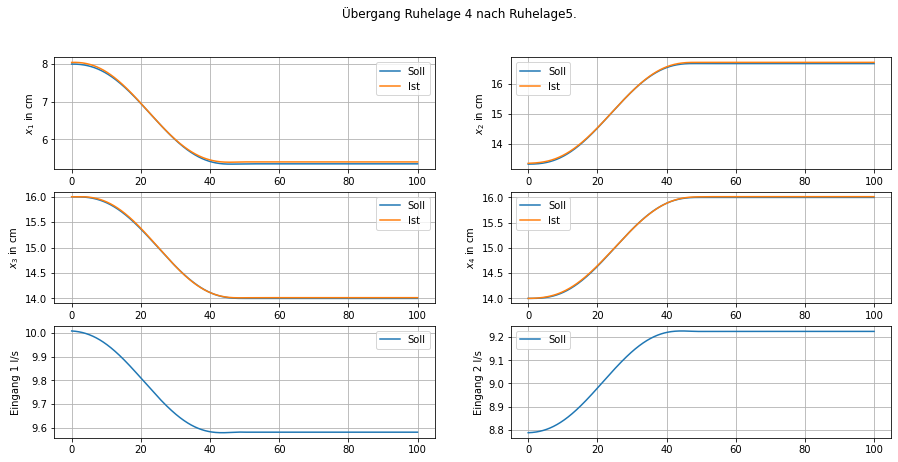

In [69]:
linear = False

#Übergangszeit für die beiden Szenarien bitte ggf. anpassen
T = [50,50] 

tank = VierTank(st)
tank_lin = tank.linearize(equis[0])

if linear:
    _tank = tank_lin
else:
    _tank = tank

for _i, _transition in enumerate(transitions):
    #Übergangszeit auslesen
    _T = T[_i]

    #Simulationszeit

    _Tsim = 2*_T

    #Anfangs- und Endwerte
    _ya = y_equi[_transition[0]-1]
    _yb = y_equi[_transition[1]-1]

    #Trajekorie generieren
    _trajectory=tank_lin.rest_to_rest_trajectory(_ya,_yb,_T,(2,2))

    #Auswertungszeitpunkte
    t_eval=np.linspace(0,_Tsim,1000)

    #Anfangszustand
    if linear:
        x0 = _trajectory.state(0)
    else:
        x0 = equis[_transition[0]-1].x


    #Solltrajektorien auswerten
    _x_soll = _trajectory.state(t_eval)
    _u_soll = _trajectory.input(t_eval)


    #Wrapper für rechte Seite der Differentialgleichung
    _ctrl = lambda t,x:_trajectory.input(t)
    _rhs = lambda t,x:_tank.model(t,x,_ctrl)


    #Simulation
    res = solve_ivp(_rhs,#zu simulierendes Modell
                    [0,Tsim],#Zeitspanne für Simulation
                    x0,#Anfangszustand
                    t_eval=t_eval,#Auswertungszeitpunkte
                    atol=1e-9,rtol=1e-6 #Toleranzen
                    )

    #Ergebnisse Plotten
    _x=res.y
    plot_results(t_eval,(_x_soll,_x),(_u_soll,))
    pp.gcf().suptitle('Übergang Ruhelage '+ str(_transition[0]) + ' nach Ruhelage' + str(_transition[1]) + '.')
    pp.show()


Der Regler folgt dem System gut, es ist im Vergleich zu anderen eine besserer Verlauf nach dem  Soll-Verlauf zu sehen. 

## e) Reglerentwurf

In [70]:
# Definition einer generischen Zustandsrückführung mit Führungsgrößenaufschaltung
def controller_closed_loop(t,x,K,trajectory):
    #skalare Argumente vektorisieren
    tv=np.atleast_1d(t)

    #Sollzustand berechnen
    x_ref=trajectory.state(tv)

    if np.isscalar(t):
        #Dimension testen, eventuell auf Matrixform bringen
        x_=np.array(x).reshape(4,1)
    else:
        x_=x

    #Regelfehler
    x_tilde=x_-x_ref

    ######-------!!!!!!Aufgabe!!!!!!-------------########
    #Hier bitte die vollständige Zustandsrückführung für das nichtlineare System einfügen
    u_tilde = trajectory.input(tv) # gewünschte Trajektorie 
    u = np.zeros((2,tv.shape[0]))
    u = u_tilde - K@x_tilde # Zustandsrückführung K@x_tilde
    ######-------!!!!!!Aufgabe Ende!!!!!!-------########

    if np.isscalar(t):
        u=u[:,0]
    return u

### Berechnen der Reglerverstärkungen

Fügen Sie hier Ihre Überlegungen zur Reglerauslegung ein.

Die Pole, also Eigenwerte des geschlossenen Regelkreises können über die folgende Formel berechnet werden: 
$\text{Pole} = \omega_0 \left( -D \pm j \sqrt{1 - D^2} \right)$ . Hierfür werden typische Werte aus der Regelungstechnik angesetzt, D= 0.6 weil dieser ein gutes Verhältnis zwischen schnellem Einschwingen und geringem Überschwingen liefert.
Die Reglerverstärkung wird dann mit den platzierten Polen über die Ackermannformel berchnet. 

In [71]:
######-------!!!!!!Aufgabe!!!!!!-------------########
#hier bitte Wunscheigenwerte des geschlossenen Regelkreises wählen und Reglerverstärkungen berechnen
# Eigenwerte des offenen Kreises


Arnfr, _, _, _, _, _ = mimo_rnf(tank_lin.A, tank_lin.B, tank_lin.C, (2, 2))
print(Arnfr)
# Berechnung der Eigenwerte der Teilsysteme
eigsys1 = np.linalg.eigvals(Arnfr[0:2, 0:2])  
eigsys2 = np.linalg.eigvals(Arnfr[2:, 2:]) 

w0 = 3 #2.2 
D = 0.6
omega_0_1 = abs(max(eigsys1)) * w0
omega_0_2 = abs(max(eigsys2)) * w0

# Berechnung der Pole
pole1 = omega_0_1 * np.array([-D + 1j * np.sqrt(1 - D ** 2), -D - 1j * np.sqrt(1 - D ** 2)]) # Eigenwerte im geschlossenen Kreis
pole2 = omega_0_2 * np.array([-D + 1j * np.sqrt(1 - D ** 2), -D - 1j * np.sqrt(1 - D ** 2)])

# Systemmatrix A und deren Eigenwerte anzeigen
print("Systemmatrix:")
display(sympy.Matrix(Arnfr.round(3)))
print("Eigenwerte der Systemmatrix:")
display(sympy.Matrix(np.linalg.eigvals(Arnfr)))

# Eigenwerte der Teilsysteme anzeigen
print("Eigenwerte offener Kreis entkoppeltes Teilsystem 1:")
display(sympy.Matrix(eigsys1.round(3)))
print("Eigenwerte offener Kreis entkoppeltes Teilsystem 2:")
display(sympy.Matrix(eigsys2.round(3)))

# Reglerstärken mit Ackermannformel bestimmen
K_pole_placement = tank_lin.acker([pole1, pole2])



######-------!!!!!!Aufgabe Ende!!!!!!-------########

#print(K_pole_placement)

print("Reglerverstärkung:")
display(sympy.Matrix(K_pole_placement.round(3)))

print("Probe (Eigenwerte geschlossener Kreis):")
display(sympy.Matrix(np.linalg.eigvals(tank_lin.A-tank_lin.B@K_pole_placement).round(3)))

print("Eigenwerte Zielregime:")
display(sympy.Matrix(np.linalg.eigvals(tank.linearize(equis[2]).A-tank.linearize(equis[2]).B@K_pole_placement).round(3)))

[[ 6.84806501e-17  1.00000000e+00  1.40466621e-18  5.68094287e-18]
 [-2.07196978e-01 -9.23291702e-01  5.40309580e-02  1.00319866e-01]
 [-9.43608406e-18  0.00000000e+00  5.91794775e-17  1.00000000e+00]
 [ 9.10865942e-02  2.36770054e-01 -2.57625872e-01 -1.02587967e+00]]
Systemmatrix:


Matrix([
[   0.0,    1.0,    0.0,    0.0],
[-0.207, -0.923,  0.054,    0.1],
[   0.0,    0.0,    0.0,    1.0],
[ 0.091,  0.237, -0.258, -1.026]])

Eigenwerte der Systemmatrix:


Matrix([
[-0.683919779104274],
[-0.538586826044615],
[-0.341959889552138],
[-0.384704875746154]])

Eigenwerte offener Kreis entkoppeltes Teilsystem 1:


Matrix([
[-0.385],
[-0.539]])

Eigenwerte offener Kreis entkoppeltes Teilsystem 2:


Matrix([
[-0.439],
[-0.587]])

Reglerverstärkung:


Matrix([
[13.812,  2.741, 68.566, -15.223],
[ 7.084, 15.139,  5.046,  59.694]])

Probe (Eigenwerte geschlossener Kreis):


Matrix([
[-0.692 + 0.923*I],
[-0.692 - 0.923*I],
[ -0.79 + 1.053*I],
[ -0.79 - 1.053*I]])

Eigenwerte Zielregime:


Matrix([
[-0.629 + 0.833*I],
[-0.629 - 0.833*I],
[ -0.86 + 1.145*I],
[ -0.86 - 1.145*I]])

### Simulation des geschlossenen Regelkreises

Passen Sie die Parameter selbständig an

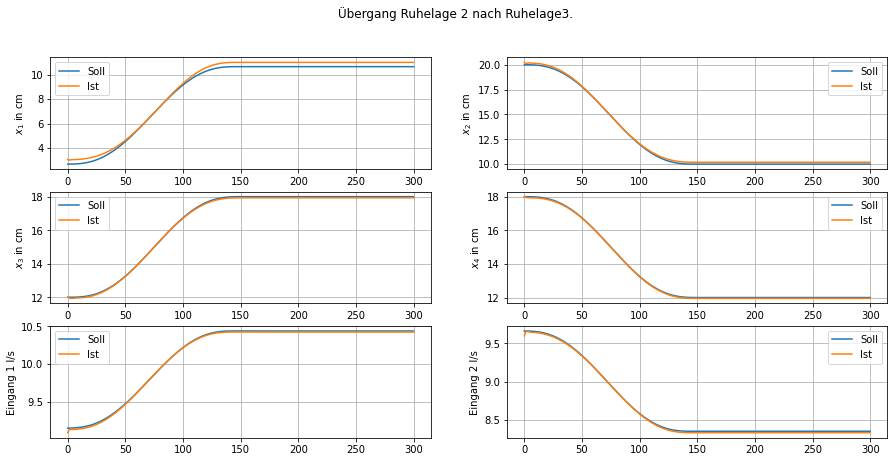

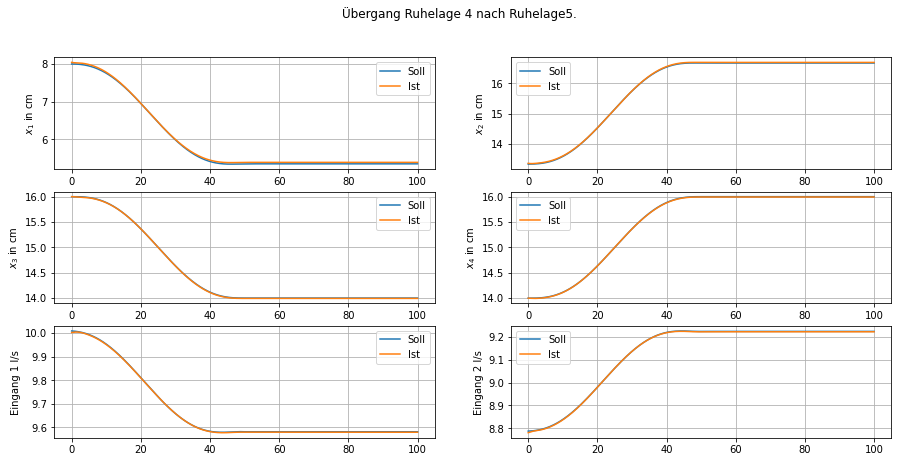

In [72]:
#Simulationsmodell linear oder nichtlinear
linear = False

#Übergangszeit für gewählte Übergänge (bitte ggf. anpassen)
T = [150,50]

tank = VierTank(st)
tank_lin = tank.linearize(equis[0])

if linear:
    _tank = tank_lin
else:
    _tank = tank

for _i, _transition in enumerate(transitions):
    #Übergangszeit auslesen
    _T = T[_i]

    #Simulationszeit

    Tsim = 2*_T

    #Anfangs- und Endwerte
    _ya = y_equi[_transition[0]-1]
    _yb = y_equi[_transition[1]-1]

    #Trajekorie generieren
    _trajectory=tank_lin.rest_to_rest_trajectory(_ya,_yb,_T,(2,2))

    #Auswertungszeitpunkte
    t_eval=np.linspace(0,Tsim,1000)


    #Anfangszustand
    if linear:
        _x0 = _trajectory.state(0)
    else:
        _x0 = equis[_transition[0]-1].x

    #Wrapper für Regler und System
    _ctrl = lambda t_,x_:controller_closed_loop(t_, x_,K_pole_placement,_trajectory)
    _rhs = lambda t_, x_:_tank.model(t_,x_,_ctrl)



    #Simulation
    res = solve_ivp(_rhs,#zu simulierendes Modell
                    [0,Tsim],#Zeitspanne für Simulation
                    _x0,#Anfangszustand
                    t_eval=t_eval,#Auswertungszeitpunkte
                    atol=1e-9,rtol=1e-6 #Toleranzen
                    )

    #Ergebnisse Plotten
    _x = res.y
    _u = _ctrl(t_eval,_x)

    #Ergebnisse Plotten
    plot_results(t_eval,
                 (_trajectory.state(t_eval),_x),
                 (_trajectory.input(t_eval),_u))

    pp.gcf().suptitle('Übergang Ruhelage '+ str(_transition[0]) + ' nach Ruhelage' + str(_transition[1]) + '.')
    pp.show()


## f) LQR Entwurf

Ergänzen Sie hier Ihre Überlegungen zum LQR-Entwurf. Die Berechnung der Reglerverstärkungen sind in der nächsten Zelle zu implementieren.

Das Gütefunktional lässt sich mit der Formel 
$$
J(x, u) = \int_0^\infty \left( x^T Q x + u^T R u \right) dt
$$
beschreiben. 
Durch die Gewichtung kann die Einstellung der Rückfühung verändert werden. Mit einer starken Gewichtung der Matrix Q werden Abweichungen vom der Zustandsgröße stärker bestraft, der Regler  schnell und aggresiv. Es kann dadurch aber auch zur Übersteuerung kommen, weshalb durch rumprobieren ein sinnvoller Wert gefunden werden kann. 

Das Quadratische Gütefunktional kann über die algebrarische Ricatti-Gleichung gelöst werden, welche in python mit der Funktion solve_continuous_are() gegeben ist. Mit der gefundenen Lösung kann dann die Rückführungsverstärkung K berechnet werden über 
$$
K_{\text{LQR}} = R^{-1} \left( B^\top P \right)
$$

In [73]:
import libtank
imp.reload(libtank)

R=np.eye(2)*1
Q=np.eye(4)*1
print("Gewichtsmatrix Q:")
display(sympy.Matrix(Q.round(3)))

print("Gewichtsmatrix R:")
display(sympy.Matrix(R.round(3)))

K_lqr=tank_lin.lqr(Q,R)

print("Reglerverstärkung:")
display(sympy.Matrix(K_lqr.round(3)))

Gewichtsmatrix Q:


Matrix([
[1.0, 0.0, 0.0, 0.0],
[0.0, 1.0, 0.0, 0.0],
[0.0, 0.0, 1.0, 0.0],
[0.0, 0.0, 0.0, 1.0]])

Gewichtsmatrix R:


Matrix([
[1.0, 0.0],
[0.0, 1.0]])

Reglerverstärkung:


Matrix([
[0.056, 0.02, 0.027, 0.003],
[0.022, 0.07, 0.016, 0.013]])

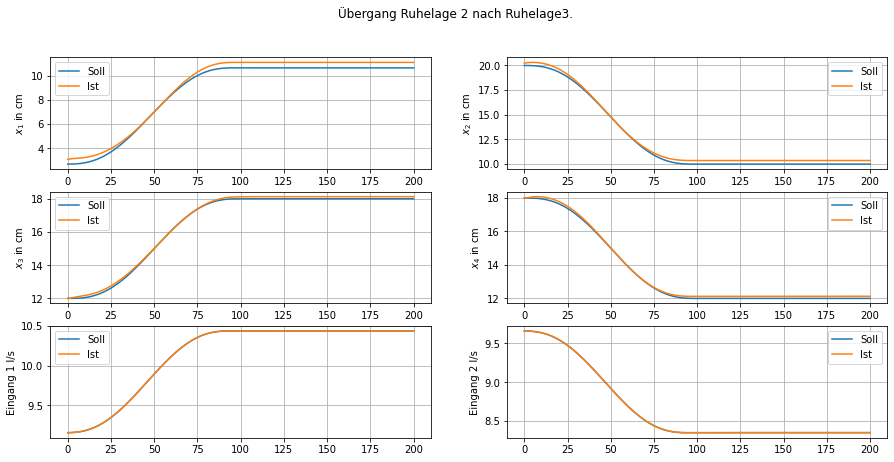

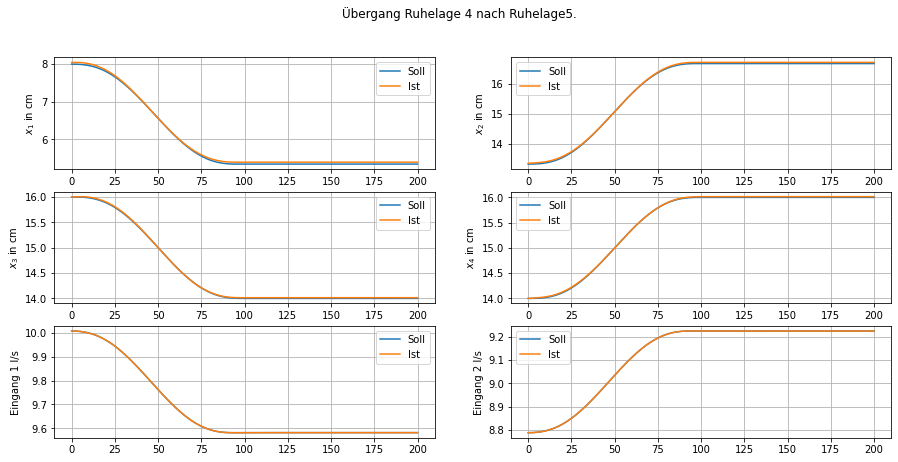

In [74]:
linear = False

#Übergangszeit bitte ggf. anpassen
T = [100,100]

tank = VierTank(st)
tank_lin = tank.linearize(equis[0])

if linear:
    _tank = tank_lin
else:
    _tank = tank

for _i, _transition in enumerate(transitions):
    #Übergangszeit auslesen
    _T = T[_i]

    #Simulationszeit

    Tsim = 2*_T

    #Anfangs- und Endwerte
    _ya = y_equi[_transition[0]-1]
    _yb = y_equi[_transition[1]-1]

    #Trajekorie generieren
    _trajectory=tank_lin.rest_to_rest_trajectory(_ya,_yb,_T,(2,2))

    #Auswertungszeitpunkte
    t_eval=np.linspace(0,Tsim,1000)


    #Anfangszustand
    if linear:
        _x0 = _trajectory.state(0)
    else:
        _x0 = equis[_transition[0]-1].x

    #Wrapper für Regler und System
    _ctrl = lambda t,x:controller_closed_loop(t,x,K_lqr,_trajectory)
    _rhs = lambda t,x:_tank.model(t,x,_ctrl)



    #Simulation
    res = solve_ivp(_rhs,#zu simulierendes Modell
                    [0,Tsim],#Zeitspanne für Simulation
                    _x0,#Anfangszustand
                    t_eval=t_eval,#Auswertungszeitpunkte
                    atol=1e-9,rtol=1e-6 #Toleranzen
                    )

    #Ergebnisse Plotten
    _x = res.y
    _u = _ctrl(t_eval,_x)

    #Ergebnisse Plotten
    plot_results(t_eval,
                 (_trajectory.state(t_eval),_x),
                 (_trajectory.input(t_eval),_u))

    pp.gcf().suptitle('Übergang Ruhelage '+ str(_transition[0]) + ' nach Ruhelage' + str(_transition[1]) + '.')
    pp.show()


# 3 Zeitdiskreter Entwurf
Das zeitdiskrete Simulationsmodell ist im wesentlichen als Schleife aufgebaut. In jedem Abtastschritt wird zunächst der Eingang aktualisiert. Im Anschluss wird das System, mit diesem Wert für den Eingang, über eine Abtastperiode simuliert.

In [75]:
def simulate_discrete(sys,x0,fkt_u,Ta,Tsim):
    #nonlinear simulation
    t_array=np.array([])
    u_array=np.zeros((2,0))
    x_array=np.zeros((len(x0),0))
    k=0
    while k*Ta<Tsim:
        u=fkt_u(k,x0)
        ctrl = lambda t,x:u
        rhs=lambda t,x:sys(t,x,ctrl)
        t_eval=[k*Ta,(k+0.01)*Ta,(k+0.99)*Ta,(k+1)*Ta]
        res=solve_ivp(rhs,[k*Ta,(k+1)*Ta],x0,atol=1e-9,rtol=1e-6,t_eval=t_eval)
        t_array=np.hstack((t_array,res.t))
        x_array=np.hstack((x_array,res.y))
        u_array=np.hstack((u_array,u.reshape((2,1))*np.ones_like(res.t)))
        k+=1
        x0=x_array[:,-1]

    return t_array,x_array,u_array

Für alle nachfolgenden zeitdiskreten Schritte muss zunächst das Systemmodell mit der gewählten Abtastschrittweite $T_a$ diskretisiert werden.

## a) Quasi-kontinuierliche Simulation

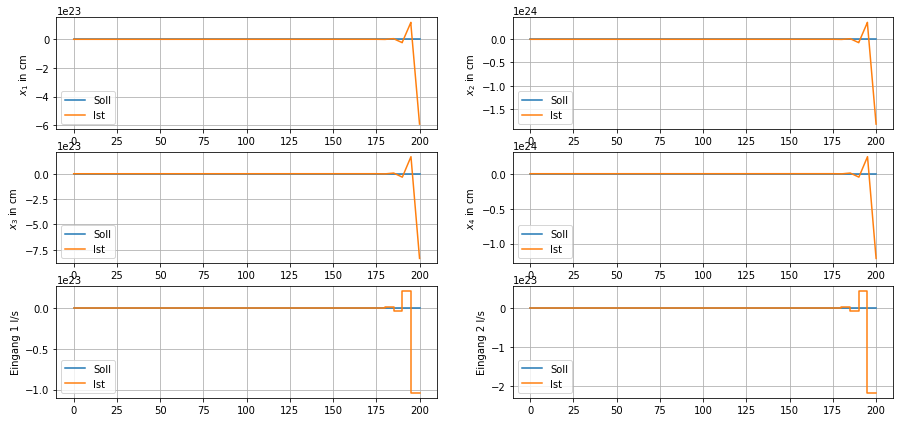

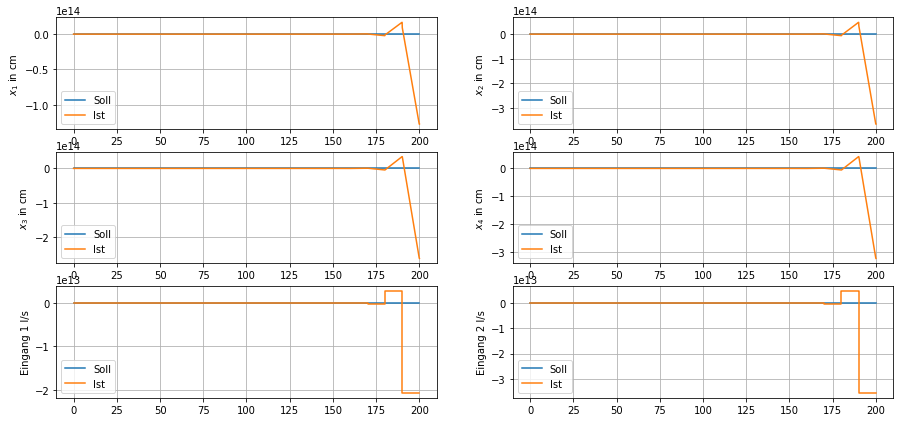

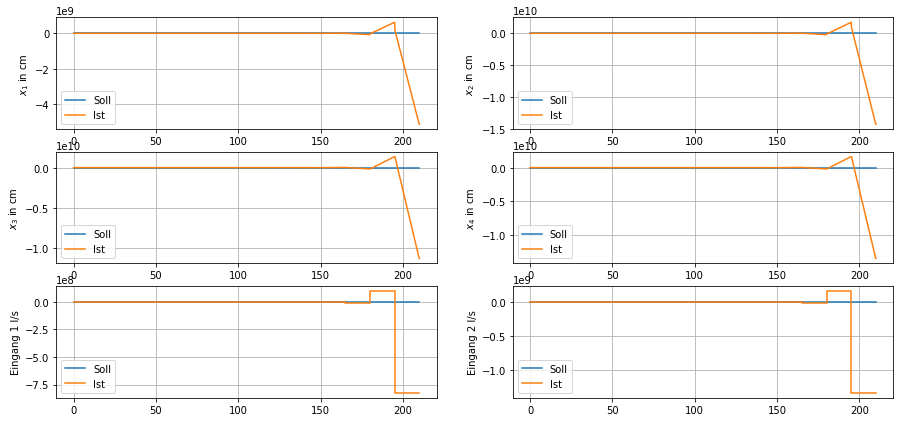

In [76]:
#Simulation mit linearem Entwurfsmodell oder nichtlinearem Modell?
linear = True

#Abtastzeiten
#Ta = [1.0, 5.0, 10.0]
Ta = [5.0, 10.0, 15.0] # laut abgabe, Regler folgt schlechter

#Simulationszeit
Tsim=200

tank = VierTank(st)
tank_lin = tank.linearize(equis[0])

if linear:
    _tank = tank_lin
else:
    _tank = tank

#Auswertungszeitpunkte
t_eval=np.linspace(0,Tsim,500)

_transition = transitions[1]
_ya = y_equi[_transition[0]-1]
_yb = y_equi[_transition[1]-1]

for _Ta in Ta:
    #Anfangszustand
    if linear:
        _x0 = _trajectory.state(0)
    else:
        _x0 = equis[_transition[0]-1].x

    #Trajekorie generieren
    _trajectory=tank_lin.rest_to_rest_trajectory(_ya,_yb,_T,(2,2))

    #Wrapper für Regler und System
    _ctrl = lambda k_,x_:controller_closed_loop(k_ * _Ta, x_, K_pole_placement,_trajectory)
    _rhs = lambda t, x, ctrl_:_tank.model(t, x, ctrl_)

    #Zeitdiskrete Simulation
    t_sim,x_sim,u_sim=simulate_discrete(_rhs, _x0, _ctrl, _Ta, Tsim)

    #Ergebnisse Plotten
    x_desired = _trajectory.state(t_sim)
    u_desired = _trajectory.input(np.floor(t_sim/_Ta)*_Ta)


    plot_results(t_sim,
                 (x_desired,x_sim),
                 (u_desired,u_sim))

## b) Ergänzen Sie hier kurz Ihre Gedanken zur Diskretisierung

In der Funktion `ContinuousLinearizedSystem` wird die Matrix A mit der Abtatszeit Ta multipliziert . 
Somit ergibt sich die diskrete A Matrix: 
$$
A_d = e^{A \cdot T_a}
$$
Und die B Matrix zu: 
$$
B_d = A^{-1} \cdot (A_d - I) \cdot B
$$
Die Simualtion des linearen Systems stimmt auch im diskreten Fall gut mit der Solltjaktorie überein.
Im Nichtlinearen Fall ist weiterhin eine große Abweichung des Solltrajektorie zu erkennen. 

## c) Zeitdiskreter Steuerungsentwurf

Anfangs und Endwerte flacher Ausgang:
[ 0.26035623 -0.24885764]
[-0.26035623  0.24885764]


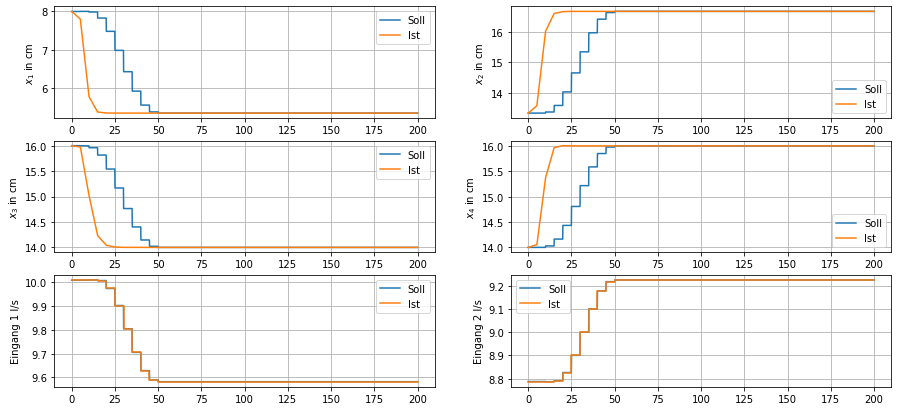

Anfangs und Endwerte flacher Ausgang:
[ 0.21455183 -0.21915147]
[-0.21455183  0.21915147]


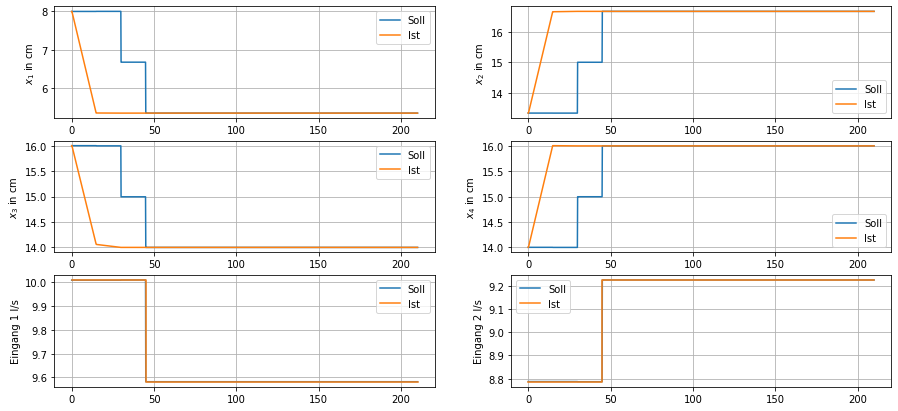

In [77]:
linear=True

Ta=[5.0,15.0]
#Ta=[0.2, 10.0, 15.0]

transition = transitions[1]
ya = y_equi[_transition[0]-1]
yb = y_equi[_transition[1]-1]

#Übergangszeit
T=50.0

#Simulationszeit
Tsim=200

tank=VierTank(st)
tank_lin = tank.linearize(equis[0])

if linear:
    _tank = tank_lin

for _Ta in Ta:
    #Schritte für Übergang
    N=np.round(T/_Ta)
    
    #diskretes Modell
    tank_lin_discrete = tank_lin.discretize(_Ta)

    #Berechne diskrete Solltrajektorien
    trajectory_discrete = tank_lin_discrete.rest_to_rest_trajectory(ya, yb,N,[2,2])

    _ctrl = lambda k,x:trajectory_discrete.input(k)

    print("Anfangs und Endwerte flacher Ausgang:")
    print(trajectory_discrete.eta_a)
    print(trajectory_discrete.eta_b)

    #Wrapper für Modell
    if linear:
        _x0 = trajectory_discrete.state(0)
    else:
        _x0 = equis[_transition[0]-1].x

    _rhs = lambda t,x,controller:_tank.model(t, x, _ctrl)

    #Zeitdiskrete Simulation
    t_sim,x_sim,u_sim=simulate_discrete(_rhs, _x0, _ctrl, _Ta, Tsim)

    #Ergebnisse Plotten
    x_desired=trajectory_discrete.state(np.floor(t_sim/_Ta))
    u_desired=trajectory_discrete.input(np.floor(t_sim/_Ta))
    y_desired=trajectory_discrete.output(np.floor(t_sim/_Ta))

    plot_results(t_sim,
                 (x_desired,x_sim),
                 (u_desired,u_sim))
    pp.show()

## d) Zeitdiskreter Reglerentwurf

Ergänzen Sie hier Ihre Überlegungen zum zeitdiskreten Reglerentwurf.

In [78]:
# Definition einer generischen diskreten Zustandsrückführung mit Führungsgrößenaufschaltung
def control_discrete_closed_loop(k,x,Kd,trajectory):
    kv=np.atleast_1d(k)
    x_desired=trajectory.state(kv)
    #Dimension testen, eventuell auf Matrixform bringen
    if np.isscalar(k):
        x_=np.array(x).reshape(4,1)
    else:
        x_=x
    x_tilde=x_-x_desired
    u_desired=trajectory.input(kv)
    u=u_desired-Kd@x_tilde
    if np.isscalar(k):
        u=u[:,0]
    return u

Die Eigenwerte des geschlossenen Regellkreises im zeitdiskreten werden nach folgender Formel angelegt (siehe dazu auch Angabe) 
$
z_i = e^(Ta \cdot si)
$
wobei si die Pole aus der Aufgabe 2e) sind 

Anfangs und Endwerte flacher Ausgang:
[ 0.55328264 -0.44569958]
[-0.55328264  0.44569958]
Anfangs und Endwerte flacher Ausgang:
[ 0.26035623 -0.24885764]
[-0.26035623  0.24885764]
Anfangs und Endwerte flacher Ausgang:
[ 0.2188875  -0.22211306]
[-0.2188875   0.22211306]


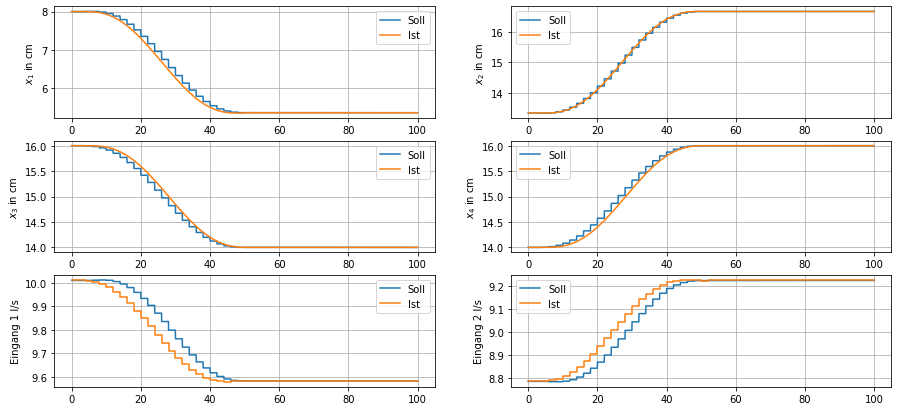

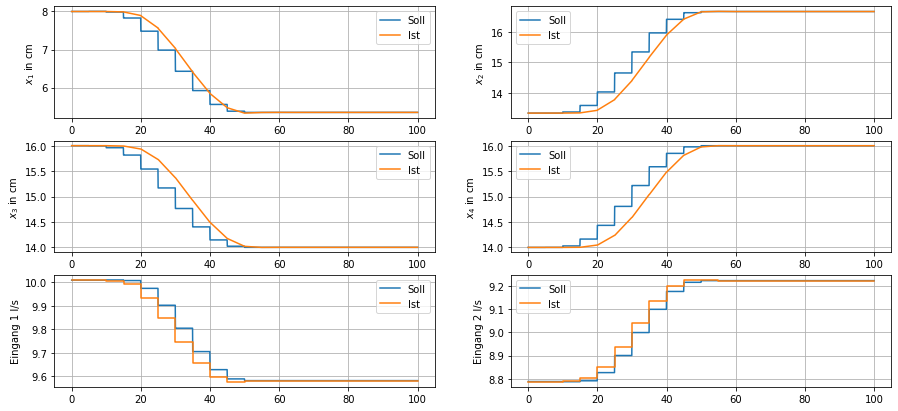

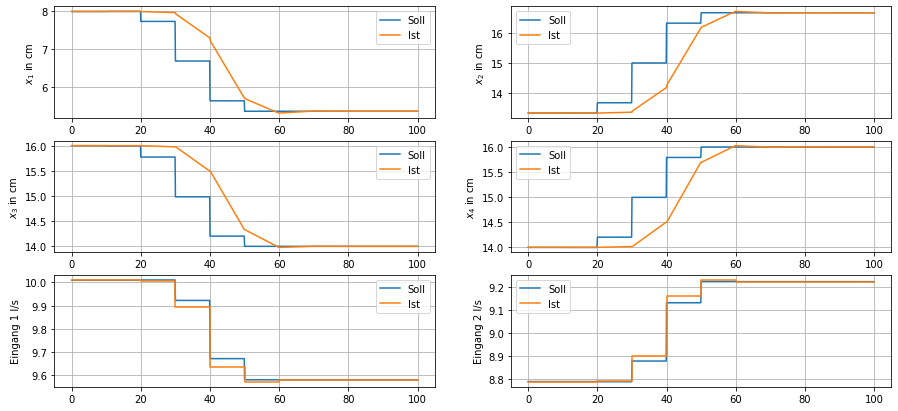

In [79]:
#Simulation mit linarem oder nichtlinearem System?
linear = True

#LQR oder Eigenwertvorgabe?
lqr = True

#zu untersuchende Abtastzeiten
Ta=[2.0,5.0,10.0]

tank=VierTank(st)
tank_lin = tank.linearize(equis[0])

if linear:
    _tank = tank_lin
else:
    _tank = tank


transition = transitions[1]
ya = y_equi[_transition[0]-1]
yb = y_equi[_transition[1]-1]

#Übergangszeit
T=50.0

#Simulationszeit
Tsim=2*T

for _Ta in Ta:
    #Schritte für Übergang
    N=np.round(T/_Ta)

    #diskretes Modell
    tank_lin_discrete = tank_lin.discretize(_Ta)

    ######-------!!!!!!Aufgabe!!!!!!-------------########
    #Bitte vervollständigen / anpassen
    if lqr: # LQR-  Entwurf
        _Kd = tank_lin_discrete.lqr(Q,R)

    else: # Eigenwertvorgabe
        #Wunschpolynom geschlossener Regelkreis
        eigsd=np.zeros(3)
        eigsd1=np.zeros_like(eigsys1)
        eigsd2=np.zeros_like(eigsys2)
        eigsd1[0]=np.exp(_Ta*pole1[0]) # Anwenden von z=e^(Ta*si) aus der Angabe 
        eigsd2[0]=np.exp(_Ta*pole2[0])
        eigsd2[1]=np.exp(_Ta*pole2[1])
        eigsd=np.array([eigsd1,eigsd2],dtype=object)
        print("Eigenwerte diskret")
        display(eigsd)
        _Kd = np.zeros((2,4))
        Kd_pole_placement=tank_lin_discrete.acker(np.array([eigsd1,eigsd2],dtype=object))
    ######-------!!!!!!Aufgabe Ende!!!!!!-------########


    #Berechne diskrete Solltrajektorien
    trajectory_discrete = tank_lin_discrete.rest_to_rest_trajectory(ya,yb,N,[2,2])

    _ctrl = lambda k,x:control_discrete_closed_loop(k,x,_Kd,trajectory_discrete)

    print("Anfangs und Endwerte flacher Ausgang:")
    print(trajectory_discrete.eta_a)
    print(trajectory_discrete.eta_b)

    #Wrapper für Modell
    if linear:
        x0=trajectory_discrete.state(0)
    else:
        x0 = equis[_transition[0]-1].x
    _rhs = lambda t,x,controller : _tank.model(t,x,controller)


    #zeitdiskrete Simulation
    t_sim, x_sim, u_sim = simulate_discrete(_rhs,x0,_ctrl,_Ta,Tsim)

    #Ergebnisse Plotten
    x_desired=trajectory_discrete.state(np.floor(t_sim/_Ta))
    u_desired=trajectory_discrete.input(np.floor(t_sim/_Ta))

    plot_results(t_sim,
                 (x_desired,x_sim),
                 (u_desired,u_sim))

In [80]:
tank.generate_model_test_data("testdata.pckl",200);
